<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
#from keras.utils.np_utils import to_categorical
#from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [ ]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2023-10-23 00:27:03--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2023-10-23 00:27:03--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0.001s  

2023-10-23 00:27:04 (16.6 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2023-10-23 00:27:04--
Total wall clock time: 0.3s
Downloaded: 1 files, 23K in 0.001s (16.6 MB/s)


### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 31.7MB/s]


In [ ]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [ ]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [ ]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

In [ ]:
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

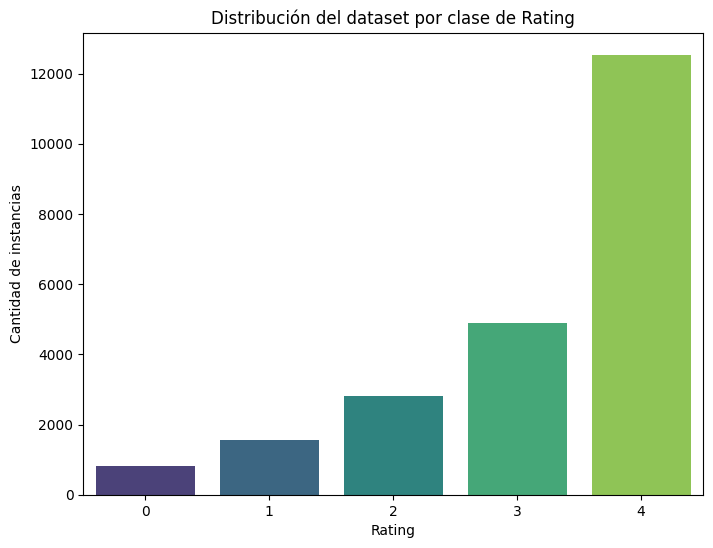

In [ ]:
# Cuenta la cantidad de instancias por clase en la columna "Rating"
rating_counts = df_reviews['Rating'].value_counts()

# Crea un gráfico de barras para visualizar la distribución
plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")
plt.xlabel("Rating")
plt.ylabel("Cantidad de instancias")
plt.title("Distribución del dataset por clase de Rating")
plt.show()

In [ ]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

# Extraer la columna "Review" y convertirla en un vector NumPy
reviews_np = np.array(df_reviews['Review Text'])

In [ ]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [ ]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
# Cuantas reviews (rows) hay para evaluar?
len(text_sequences)


22641

In [ ]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [ ]:
# Alumno: ¿Cuál es la longitud de ese corpus?
longitud_corpus = len(corpus)

print("Longitud del corpus:", longitud_corpus)

Longitud del corpus: 7011643


In [ ]:
# Alumno: ¿Cuál es la longitud de ese corpus?

In [ ]:
# Calcula la longitud del corpus
longitud_del_corpus = len(corpus)

# Imprime la longitud del corpus
print(f"La longitud del corpus es: {longitud_del_corpus} caracteres")

La longitud del corpus es: 7011643 caracteres


In [ ]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [ ]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

In [ ]:
# Muestra los primeros 20 tokens
primeros_20_tokens = tokens[:20]
print(primeros_20_tokens)

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


In [ ]:
# Alumno: ¿Cuántos tokens/palabras hay?

In [ ]:
# Calcula la cantidad de tokens
cantidad_de_tokens = len(tokens)

# Imprime la cantidad de tokens
print(f"La cantidad de tokens en la lista es: {cantidad_de_tokens}")

La cantidad de tokens en la lista es: 1372203


In [ ]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer

# Definir el número máximo de palabras a utilizar
num_words = 2000
vocab_size = num_words

# Crear una instancia del Tokenizer
tok = Tokenizer(num_words=num_words)

# Ajustar el Tokenizer a tus tokens
tok.fit_on_texts(tokens)


In [ ]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

In [ ]:
# Obtener el diccionario de palabra a índice (índice de palabra)
word_index = tok.word_index
len(word_index)

14847

In [ ]:
# Alumno: Convertir las palabras/tokens a números

In [ ]:
# Convertir tus textos en secuencias de números enteros
# Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [ ]:
sequences[0][:10]

[253, 532, 917, 3, 662, 3, 68]

In [ ]:
# Alumno: Determinar cual es la oración más larga

In [71]:
# Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [72]:
# Inicializa una variable para almacenar la longitud máxima
longitud_maxima = 0

# Inicializa una variable para almacenar la oración más larga
oracion_mas_larga = []

# Recorre las secuencias y encuentra la más larga
for secuencia in sequences:
    longitud_actual = len(secuencia)
    if longitud_actual > longitud_maxima:
        longitud_maxima = longitud_actual
        oracion_mas_larga = secuencia

# Convierte la secuencia de números enteros de nuevo a palabras
oracion_mas_larga_palabras = [word for word, index in word_index.items() if index in oracion_mas_larga]

# Imprime la oración más larga y su longitud
print("Oración más larga:")
print(" ".join(oracion_mas_larga_palabras))
print(f"Longitud de la oración más larga: {longitud_maxima} tokens")

Oración más larga:
the i and a it is this to in on of was so my that love size top are like it's i'm or you they up if really one an out had cute when bit large material tried store usually get only could black feel go looked 2 try saw tops while two came xl once new brand local least 1 ran busty broad maeve barely motif shame missing checked
Longitud de la oración más larga: 115 tokens


In [73]:
# Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from torch_helpers import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [74]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [75]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

# Transformar la columna "Rating" en codificación one-hot
y = pd.get_dummies(df_reviews['Rating'], columns=['Rating'])

# Verificar la forma de y
print("Shape de y:", y.shape)

Shape de y: (22641, 5)


In [ ]:
y

,0,1,2,3,4
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
23481,0,0,0,0,1
23482,0,0,1,0,0
23483,0,0,1,0,0
23484,0,0,1,0,0


In [76]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

test_size = 0.2

# Realizar la división en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [77]:
# Alumno: determinar la dimensiones de entrada y salida
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]
print(input_shape)
print(output_shape)

115
5


In [66]:
from imblearn.over_sampling import RandomOverSampler

# Crear una instancia del oversampler
oversampler = RandomOverSampler(random_state=42)



### 2 - Entrenar el modelo con Embeddings + LSTM

In [79]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dropout, Dense

In [80]:
input_length = 115
embedding_dim = 1000
# Crear un modelo Sequential
model = Sequential()

# Agregar una capa de Embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))

# Agregar una capa LSTM
model.add(LSTM(units=128, activation='relu'))  # Puedes ajustar los hiperparámetros según sea necesario

# Agregar una capa de Dropout para regularización
model.add(Dropout(0.2))  # Puedes ajustar la tasa de dropout según sea necesario

# Agregar una capa densa de salida (asumiendo 5 clases en tu caso)
model.add(Dense(5, activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Evaluar el modelo
score = model.evaluate(X_test, y_test, verbose=0)
print('Puntuación de prueba:', score[0])
print('Exactitud de prueba:', score[1])

Epoch 1/5
283/283 [==============================] - ETA: 0s - loss: 124.3943 - accuracy: 0.5536

KeyboardInterrupt: ignored

Se puede observar que se alcanza un nivel de precisión del 55%. Esta cifra podría deberse al desequilibrio en la distribución de las clases, lo que podría introducir un sesgo hacia la clase mayoritaria. Dada la gran disparidad entre las clases, es posible que el modelo acierte simplemente debido a este desequilibrio.